# Feed Forward Neural Network HW2

## Download GloVe Embeddings

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
!unzip glove*.zip

## Transform GloVe embeddings to Word2Vec format

In [3]:
from gensim.scripts.glove2word2vec import glove2word2vec
import pandas as pd

glove_input_file = 'glove.6B.300d.txt'
w2v_output_file = 'glv_with_w2v_format.txt'

glove2word2vec(glove_input_file, w2v_output_file)

(400000, 300)

## Imports

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import KeyedVectors

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('popular')
stopwords = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

!pip install torchmetrics
import torchmetrics

## Load Data Set

In [68]:
#Reading the csv file
#csv outline [index|url|rating|review]
df = pd.read_csv("/content/imdb-reviews.csv", sep='\t')

#we make a column with {0, 1} based on rating
df["result"] = np.where(df["rating"] <= 4, 0, 1)

##### !! put the path for the test dataset here  !! #######
test_df = pd.DataFrame()

## Data Pre-processing



In [69]:
def data_preprocessing(df):
  # remove html tags
  df['review'] = df['review'].apply(lambda s: re.sub('<.*?>', '', s))

  # remove special chars and numbers
  df['review'] = df['review'].str.replace("[^A-Za-z]+", ' ', regex=True)

  # tokenize
  df['review'] = df['review'].apply(word_tokenize)

  # remove stopwords
  df['review'] = df['review'].apply(lambda s: ([word.lower() for word in s if word not in (stopwords)]))

  # lemmatize
  df['review'] = df['review'].apply(lambda s: ([lemmatizer.lemmatize(word) for word in s]))

  # we don't use stemming cause it ruins some words and then we can't find them in glove

  return df

df = data_preprocessing(df)

#we also processing the test data if exists
if not test_df.empty:
  test_df = data_preprocessing(test_df)

## Create the Set of Tensors for the Reviews

In [70]:
word2vec = KeyedVectors.load_word2vec_format(w2v_output_file, datatype=float, binary=False)

In [71]:
model_dict = {}
tensors_x = []
tensors_y = []

#we make the word2vec a dict to have fast searches
for word in word2vec.index2entity:
  model_dict[word] = word2vec.get_vector(word)

def reviews_to_tensors(df):

  #iterate through all of the reviews and results
  for (review, result) in zip(df['review'], df['result']):

    ##########################  tfidf ##########################

    # tfidf = TfidfVectorizer()
    # response = tfidf.fit_transform(review)

    # feature_array = np.array(tfidf.get_feature_names())
    # tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

    # importand_words = feature_array[tfidf_sorting][:25]
    
    ############ replace review in for with importand_words ############

    #for each review keep in a dict only the distinct words
    review_dict = {}
    for word in review:
      if review_dict.get(word) == None:
        review_dict[word] = len(review_dict)
    
    #for each distict word get the vector
    tensor_x = np.zeros(300)
    tensor_y = [float(result)]
    count = 0

    for word in review_dict:
        #if vector exist add it in review_vectors
        if word in model_dict:
          #add up all vectors
          tensor_x += model_dict[word]
          count += 1
    
    #devide final vector by the sum of words
    tensor_x /= count

    #add tensor to the list
    tensors_x.append(torch.tensor(tensor_x, dtype=torch.float))
    tensors_y.append(torch.tensor(tensor_y, dtype=torch.float))

  #stack all the tensors
  x = torch.stack(tensors_x)
  y = torch.stack(tensors_y)

  return x, y

x, y = reviews_to_tensors(df)

## Split Train and Test Sets

In [72]:
#split the tensors to train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(x, y, train_size=0.9, random_state=42)

In [74]:
#if case for running the test dataframe
if not test_df.empty:
  test_df['result'] = np.where(test_df['rating'] <= 4, 0, 1)
  X_test, Y_test = reviews_to_tensors(test_df)

## Define the Neural Network Class

In [75]:
class Net(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):

        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1) 
        #self.dropout1 = nn.Dropout(0.3)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(H1, H2)
        #self.dropout2 = nn.Dropout(0.3)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(H2, H3)
        #self.dropout3 = nn.Dropout(0.5)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(H3, D_out)

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out)
        out = self.relu3(out)
        out = self.linear4(out)
        return torch.sigmoid(out)

## Tune the hyperparameters

In [76]:
#Define layer sizes
D_in = X_train.shape[1]
H1 = 128
H2 = 64
H3 = 32
D_out = 1 #always 1

#Different layers sizes
#128 64 32 | 128 64 16 | 128 32 16 | 64 32 8 |  256 128 64 | 256 64 16
######################################################################

#Define Hyperparameters
learning_rate = 1e-4

#learning_rate = 1e-5 #low precision
#learning_rate = 1e-3 #overfit

#Initialise model
model = Net(D_in, H1, H2, H3, D_out)

#Loss function
loss_func = nn.MSELoss(reduction='sum')

#loss_func = nn.BCELoss(reduction='sum')
#loss_func = nn.HuberLoss(reduction='sum')

#optimizer
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, nesterov=True, lr=learning_rate)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)

## Initialize the train and test dataloader

In [77]:
nepoch = 25

batch_size = 64
#batch_size = 128
#batch_size = 32

#Initialise dataloader
dataset_train = torch.utils.data.TensorDataset(X_train, Y_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size)

dataset_test = torch.utils.data.TensorDataset(X_test, Y_test)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size)

## Evaluation Functions

In [78]:
accuracy = torchmetrics.Accuracy(task='binary', num_classes=1)
precission = torchmetrics.Precision(task='binary', num_classes=1)
recall = torchmetrics.Recall(task='binary', num_classes=1)
f1 = torchmetrics.F1Score(task='binary', num_classes=1)

## Train and Test Network

In [79]:
torch.set_grad_enabled(True)

list_loss_train = []
list_loss_test = []

list_accuracy_train = []
list_accuracy_test = []

for epoch in range(nepoch):
  batch_losses_train = 0
  batch_accuracy_train = 0
  batch_precission_train = 0
  batch_recall_train = 0
  batch_f1_train = 0

  batch_losses_test = 0
  batch_accuracy_test = 0
  batch_precission_test = 0
  batch_recall_test = 0
  batch_f1_test = 0

  #for every epoch we train the model
  for x_batch, y_batch in dataloader_train:
    y_pred = model(x_batch)

    #we find loss
    loss = loss_func(y_pred, y_batch)

    #Delete previously stored gradients
    optimizer.zero_grad()

    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()

    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()

    batch_losses_train += loss.item()
    batch_accuracy_train += accuracy(torch.round(y_pred), y_batch)
    batch_precission_train += precission(torch.round(y_pred), y_batch)
    batch_recall_train += recall(torch.round(y_pred), y_batch)
    batch_f1_train += f1(torch.round(y_pred), y_batch)

  #keep values for the curves
  list_loss_train.append(batch_losses_train/len(dataloader_train))
  list_accuracy_train.append(batch_accuracy_train/len(dataloader_train))

  print(f"Epoch {epoch}")
  print(f"  Train {epoch:3}: Loss = {batch_losses_train/len(dataloader_train):.5f} Accuracy = {batch_accuracy_train/len(dataloader_train):.5f} Precission = {batch_precission_train/len(dataloader_train):.5f} Recall = {batch_recall_train/len(dataloader_train):.5f} F1 = {batch_f1_train/len(dataloader_train):.5f}")

  #for every epoch we test the model
  list_y_pred = []
  for x_batch, y_batch in dataloader_test:
      y_pred = model(x_batch)

      batch_losses_test += loss_func(y_pred, y_batch).item()
      batch_accuracy_test += accuracy(torch.round(y_pred), y_batch)
      batch_precission_test += precission(torch.round(y_pred), y_batch)
      batch_recall_test += recall(torch.round(y_pred), y_batch)
      batch_f1_test += f1(torch.round(y_pred), y_batch)
    
  #keep values for the curves
  list_loss_test.append(batch_losses_test/len(dataloader_test))
  list_accuracy_test.append(batch_accuracy_test/len(dataloader_test))

  print(f"  Test {epoch:4}: Loss = {batch_losses_test/len(dataloader_test):.5f} Accuracy = {batch_accuracy_test/len(dataloader_test):.5f} Precission = {batch_precission_test/len(dataloader_test):.5f} Recall = {batch_recall_test/len(dataloader_test):.5f} F1 = {batch_f1_test/len(dataloader_test):.5f}")



Epoch 0
  Train   0: Loss = 15.61194 Accuracy = 0.55923 Precission = 0.33978 Recall = 0.13574 F1 = 0.18285
  Test    0: Loss = 14.54378 Accuracy = 0.74116 Precission = 0.84037 Recall = 0.59610 F1 = 0.69411
Epoch 1
  Train   1: Loss = 12.60355 Accuracy = 0.77343 Precission = 0.80975 Recall = 0.71995 F1 = 0.75560
  Test    1: Loss = 10.63871 Accuracy = 0.78472 Precission = 0.77209 Recall = 0.80417 F1 = 0.78583
Epoch 2
  Train   2: Loss = 9.63734 Accuracy = 0.80088 Precission = 0.80240 Recall = 0.79974 F1 = 0.79825
  Test    2: Loss = 9.12291 Accuracy = 0.80211 Precission = 0.78579 Recall = 0.82824 F1 = 0.80441
Epoch 3
  Train   3: Loss = 8.60162 Accuracy = 0.81508 Precission = 0.81547 Recall = 0.81517 F1 = 0.81275
  Test    3: Loss = 8.50652 Accuracy = 0.81356 Precission = 0.79519 Recall = 0.84263 F1 = 0.81629
Epoch 4
  Train   4: Loss = 8.12659 Accuracy = 0.82250 Precission = 0.82334 Recall = 0.82170 F1 = 0.81998
  Test    4: Loss = 8.17094 Accuracy = 0.81994 Precission = 0.79992 Recall

## Plots

### Optimization Learning Curve

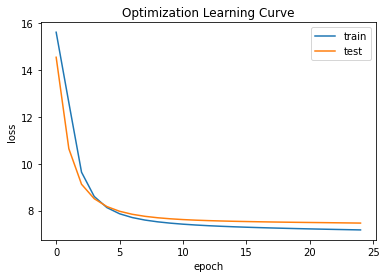

In [80]:
plt.xlabel('epoch')
plt.ylabel('loss')

plt.plot(list_loss_train, label = 'train')
plt.plot(list_loss_test, label = 'test')
plt.title('Optimization Learning Curve')
plt.legend()

### Performance Learning Curve

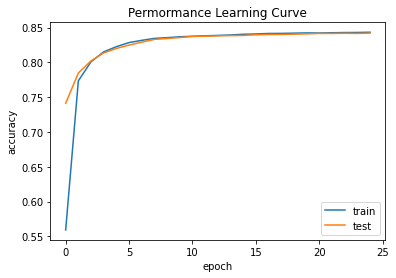

In [81]:
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.plot(list_accuracy_train, label = 'train')
plt.plot(list_accuracy_test, label = 'test')

plt.title('Permormance Learning Curve')
plt.legend()

### ROC curve

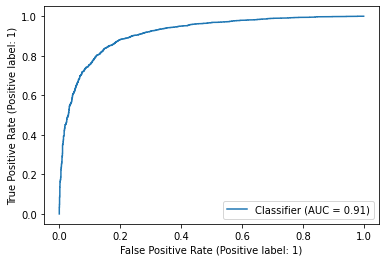

In [82]:
y_pred = model(X_test)
RocCurveDisplay.from_predictions(Y_test, y_pred.detach().numpy())